<a href="https://colab.research.google.com/github/Tessellate-Imaging/Monk_Object_Detection/blob/master/application_model_zoo/Example%20-%20Lara%20Traffic%20Lights%20Detection%20Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goals

## 1. Install [Monk Object Detection Library](https://github.com/Tessellate-Imaging/Monk_Object_Detection)
## 2. Use pretrained model to detect the traffic lights.
## 3. Train a traffic light detection model from scratch.

## Installation¶
- Run these commands
    - git clone https://github.com/Tessellate-Imaging/Monk_Object_Detection.git
    - cd Monk_Object_Detection/16_mmdet/installation

- Select the right file and run
    - chmod +x install.sh && ./install.sh

In [ ]:
! git clone https://github.com/Tessellate-Imaging/Monk_Object_Detection.git

In [ ]:
! cd Monk_Object_Detection/16_mmdet/installation && chmod +x install.sh && ./install.sh

## Using Pretrained model for detection

In [ ]:
import os
import sys
sys.path.append("Monk_Object_Detection/16_mmdet/lib")

In [ ]:
from infer_engine import Infer
gtf = Infer();

In [ ]:
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1XLSAp7YAYBY8xwKURiehj_uerHTJeq5n' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1XLSAp7YAYBY8xwKURiehj_uerHTJeq5n" -O obj_traffic2_trained.zip && rm -rf /tmp/cookies.txt

In [ ]:
! unzip -qq obj_traffic2_trained.zip

In [ ]:
gtf.Model_Params("work_dirs/config_updated/config_updated.py", 
                 "work_dirs/config_updated/latest.pth")

In [ ]:
result = gtf.Predict(img_path="Test_images/test1.jpg",
           out_img_path="result.jpg",
           thresh=0.8);
from IPython.display import Image
Image(filename='result.jpg')

In [ ]:
result = gtf.Predict(img_path="Test_images/test2.jpg",
           out_img_path="result.jpg",
           thresh=0.8);
from IPython.display import Image
Image(filename='result.jpg')

In [ ]:
result = gtf.Predict(img_path="Test_images/test8.jpg",
           out_img_path="result.jpg",
           thresh=0.8);
from IPython.display import Image
Image(filename='result.jpg')

In [ ]:
result = gtf.Predict(img_path="Test_images/test10.jpg",
           out_img_path="result.jpg",
           thresh=0.8);
from IPython.display import Image
Image(filename='result.jpg')

## Training a traffic light detection model from scratch

### Steps involved
1. Downloading Dataset
2. Converting CVML annotation format to COCO format
3. Training the model using [MMDet](https://github.com/open-mmlab/mmdetection) 

## 1. Downloading Dataset
Dataset Credits: http://www.lara.prd.fr/benchmarks/trafficlightsrecognition

In [33]:
!wget http://s150102174.onlinehome.fr/Lara/files/Lara_UrbanSeq1_JPG.zip

--2020-08-27 18:08:00--  http://s150102174.onlinehome.fr/Lara/files/Lara_UrbanSeq1_JPG.zip
Resolving s150102174.onlinehome.fr (s150102174.onlinehome.fr)... 217.160.0.161
Connecting to s150102174.onlinehome.fr (s150102174.onlinehome.fr)|217.160.0.161|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 479405386 (457M) [application/zip]
Saving to: ‘Lara_UrbanSeq1_JPG.zip.2’

Lara_UrbanSeq1_JPG. 100%[===================>] 457.20M   475KB/s    in 16m 39s 

2020-08-27 18:24:40 (468 KB/s) - ‘Lara_UrbanSeq1_JPG.zip.2’ saved [479405386/479405386]



### Unzip the dataset

In [ ]:
!unzip Lara_UrbanSeq1_JPG.zip

In [ ]:
import os

In [26]:
text_file = open('Lara3D_UrbanSeq1_JPG/files.txt')
file_content = text_file.readlines()

'frame_000772.jpg'

### Downloading Annotation file

In [ ]:
!wget http://s150102174.onlinehome.fr/Lara/files/Lara_UrbanSeq1_GroundTruth_cvml.xml

## 2. Converting CVML annotation format to COCO format
This step is required as annotation given with the dataset is of CVML format thus it needs to be converted to COCO format.

Refer to this blog for more details: [CVML Annotation — What it is and How to Convert it?](https://medium.com/towards-artificial-intelligence/cvml-annotation-what-it-is-and-how-to-convert-it-7b818dc30c9f)

### CVML to Monk Type

In [30]:
import os
import sys
import numpy as np
import pandas as pd
import xmltodict
import json
from tqdm.notebook import tqdm
import collections
from pycocotools.coco import COCO

img_dir = "Lara3D_UrbanSeq1_JPG/";

annoFile="Lara_UrbanSeq1_GroundTruth_cvml.xml"
f = open(annoFile, 'r');
my_xml = f.read();
anno = dict(dict(xmltodict.parse(my_xml))["dataset"])


combined=[]
count=0;
for frame in tqdm(anno['frame']):
    fname=file_content[count].strip()
    count+=1
    label_str = "";
    width=640
    height=480
    if(type(frame["objectlist"]) ==collections.OrderedDict):
        if(type(frame["objectlist"]['object']) == list):
            for j,i in enumerate(frame['objectlist']['object']):
                x1=max(int(i['box']['@xc'])-int(i['box']['@w'])/2,0)
                y1=max(int(i['box']['@yc'])-int(i['box']['@h'])/2,0)
                x2=min(int(i['box']['@xc'])+int(i['box']['@w'])/2,width)
                y2=min(int(i['box']['@yc'])+int(i['box']['@h'])/2,height)
                label=i['hypothesislist']['hypothesis']['subtype']['#text']
                label_str+=str(x1)+" "+str(y1)+" "+str(x2)+" "+str(y2)+" "+label+" "

        else:
            x1=max(0,int(frame["objectlist"]['object']['box']['@xc'])-int(frame["objectlist"]['object']['box']['@w'])/2)
            y1=max(0,int(frame["objectlist"]['object']['box']['@yc'])-int(frame["objectlist"]['object']['box']['@h'])/2)
            x2=min(width,int(frame["objectlist"]['object']['box']['@xc'])+int(frame["objectlist"]['object']['box']['@w'])/2)
            y2=min(height,int(frame["objectlist"]['object']['box']['@yc'])+int(frame["objectlist"]['object']['box']['@h'])/2)
            label=frame["objectlist"]['object']['hypothesislist']['hypothesis']['subtype']['#text']
            label_str += str(x1)+" "+str(y1)+" "+str(x2)+" "+str(y2)+" " + label
        
    combined.append([fname,label_str.strip()])

In [32]:
df = pd.DataFrame(combined, columns = ['ID', 'Label']);
df.to_csv("train_labels.csv", index=False);

### Monk to COCO

In [10]:
import os
import numpy as np 
import cv2
import dicttoxml
import xml.etree.ElementTree as ET
from xml.dom.minidom import parseString
from tqdm import tqdm
import shutil
import json
import pandas as pd

root = "./";
img_dir = "Lara3D_UrbanSeq1_JPG/";
anno_file = "train_labels.csv";


dataset_path = root;
images_folder = root + "/" + img_dir;
annotations_path = root + "/annotations/";


if not os.path.isdir(annotations_path):
    os.mkdir(annotations_path)
    
input_images_folder = images_folder;
input_annotations_path = root + "/" + anno_file;


output_dataset_path = root;
output_image_folder = input_images_folder;
output_annotation_folder = annotations_path;

tmp = img_dir.replace("/", "");
output_annotation_file = output_annotation_folder + "/instances_" + tmp + ".json";
output_classes_file = output_annotation_folder + "/classes.txt";


if not os.path.isdir(output_annotation_folder):
    os.mkdir(output_annotation_folder);

df = pd.read_csv(input_annotations_path);
columns = df.columns


delimiter = " ";


list_dict = [];
anno = [];
for i in range(len(df)):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = str(labels).split(delimiter);
    for j in range(len(tmp)//5):
        label = tmp[j*5+4];
        if(label not in anno):
            anno.append(label);
    anno = sorted(anno)
    
for i in tqdm(range(len(anno))):
    tmp = {};
    tmp["supercategory"] = "master";
    tmp["id"] = i;
    tmp["name"] = anno[i];
    list_dict.append(tmp);

anno_f = open(output_classes_file, 'w');
for i in range(len(anno)):
    anno_f.write(anno[i] + "\n");
anno_f.close();


coco_data = {};
coco_data["type"] = "instances";
coco_data["images"] = [];
coco_data["annotations"] = [];
coco_data["categories"] = list_dict;
image_id = 0;
annotation_id = 0;


for i in tqdm(range(len(df))):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = str(labels).split(delimiter);
    image_in_path = input_images_folder + "/" + img_name;
    img = cv2.imread(image_in_path, 1);
    h, w, c = img.shape;

    images_tmp = {};
    images_tmp["file_name"] = img_name;
    images_tmp["height"] = h;
    images_tmp["width"] = w;
    images_tmp["id"] = image_id;
    coco_data["images"].append(images_tmp);
    

    for j in range(len(tmp)//5):
        x1 = float(tmp[j*5+0]);
        y1 = float(tmp[j*5+1]);
        x2 = float(tmp[j*5+2]);
        y2 = float(tmp[j*5+3]);
        label = tmp[j*5+4];
        annotations_tmp = {};
        annotations_tmp["id"] = annotation_id;
        annotation_id += 1;
        annotations_tmp["image_id"] = image_id;
        annotations_tmp["segmentation"] = [];
        annotations_tmp["ignore"] = 0;
        annotations_tmp["area"] = (x2-x1)*(y2-y1);
        annotations_tmp["iscrowd"] = 0;
        annotations_tmp["bbox"] = [x1, y1, x2-x1, y2-y1];
        annotations_tmp["category_id"] = anno.index(label);

        coco_data["annotations"].append(annotations_tmp)
    image_id += 1;

outfile =  open(output_annotation_file, 'w');
json_str = json.dumps(coco_data, indent=4);
outfile.write(json_str);
outfile.close();

## Training Model

In [ ]:
import os
import sys
sys.path.append("Monk_Object_Detection/16_mmdet/lib")

In [ ]:
from train_engine import Detector

gtf = Detector();

In [ ]:
img_dir = "Lara3D_UrbanSeq1_JPG";
annofile = "annotations/instances_Lara3D_UrbanSeq1_JPG.json"
class_file = "annotations/classes.txt"

In [ ]:
gtf.Train_Dataset(img_dir, annofile, class_file);

In [ ]:
gtf.Dataset_Params(batch_size=8, num_workers=2)

gtf.Model_Params(model_name="faster_rcnn_fpn50");

gtf.Hyper_Params(lr=0.02, momentum=0.9, weight_decay=0.0001);

In [ ]:
gtf.Training_Params(num_epochs=50, val_interval=1);
gtf.Train();

### Run Inference on test images

In [1]:
import os
import sys
sys.path.append("Monk_Object_Detection/16_mmdet/lib")

In [2]:
from infer_engine import Infer
gtf=Infer();

/home/ubuntu/.virtualenvs/fire/lib/python3.6/site-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "


In [3]:
gtf.Model_Params("work_dirs/config_updated/config_updated.py", 
                 "work_dirs/config_updated/latest.pth")

Inference Time: 0.29312992095947266 sec
Saving Time: 0.08885741233825684 sec


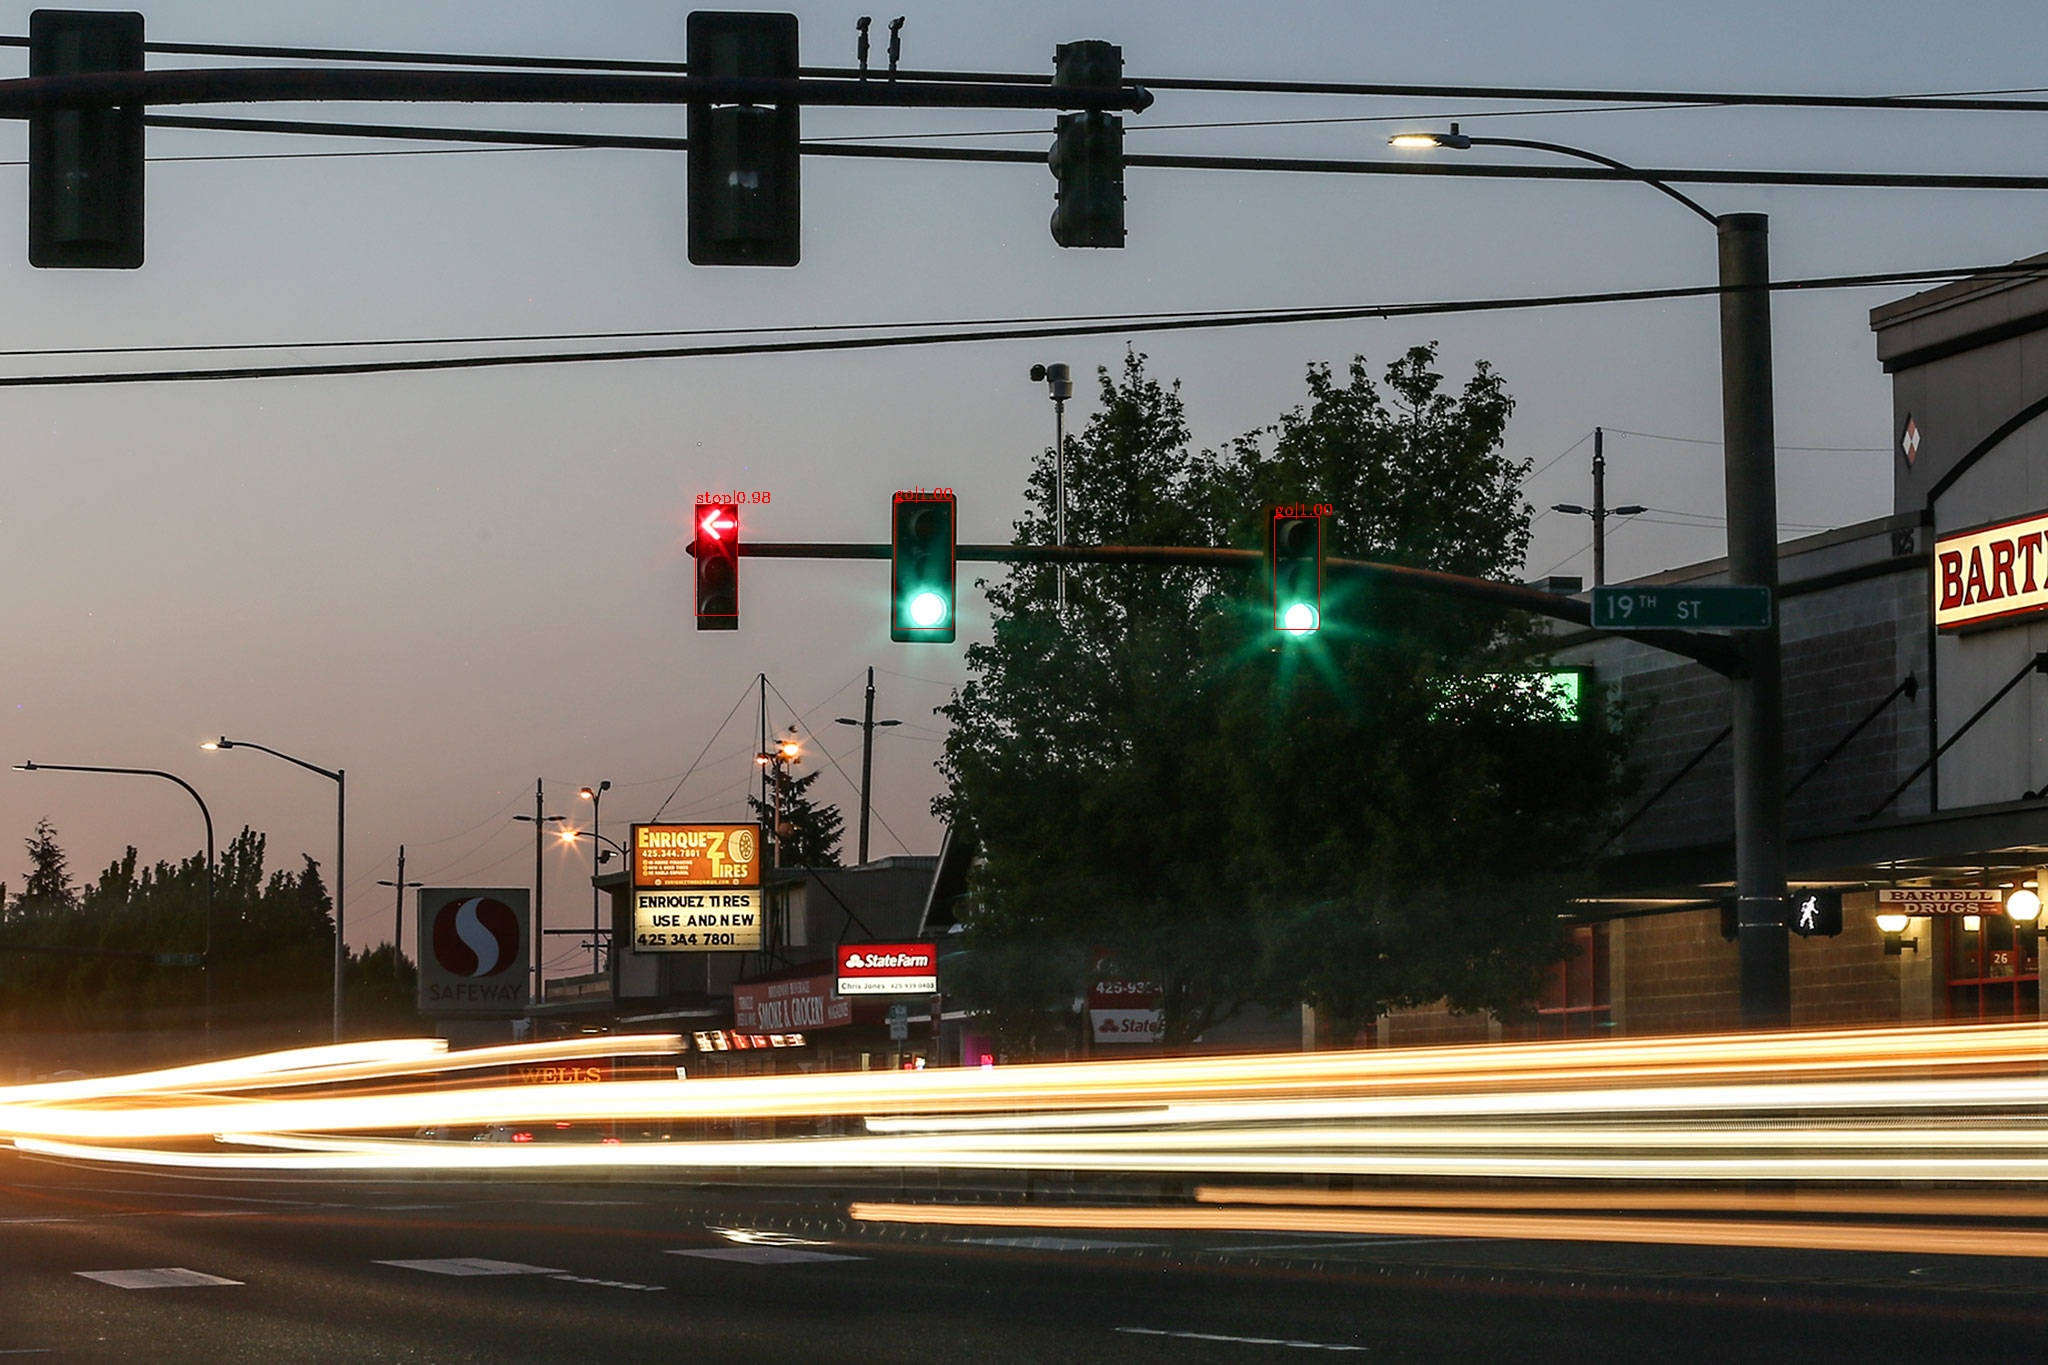

In [4]:
result = gtf.Predict(img_path="Test_images/test1.jpg",
           out_img_path="result.jpg",
           thresh=0.8);
from IPython.display import Image
Image(filename='result.jpg')

Inference Time: 0.06954169273376465 sec
Saving Time: 0.04408597946166992 sec


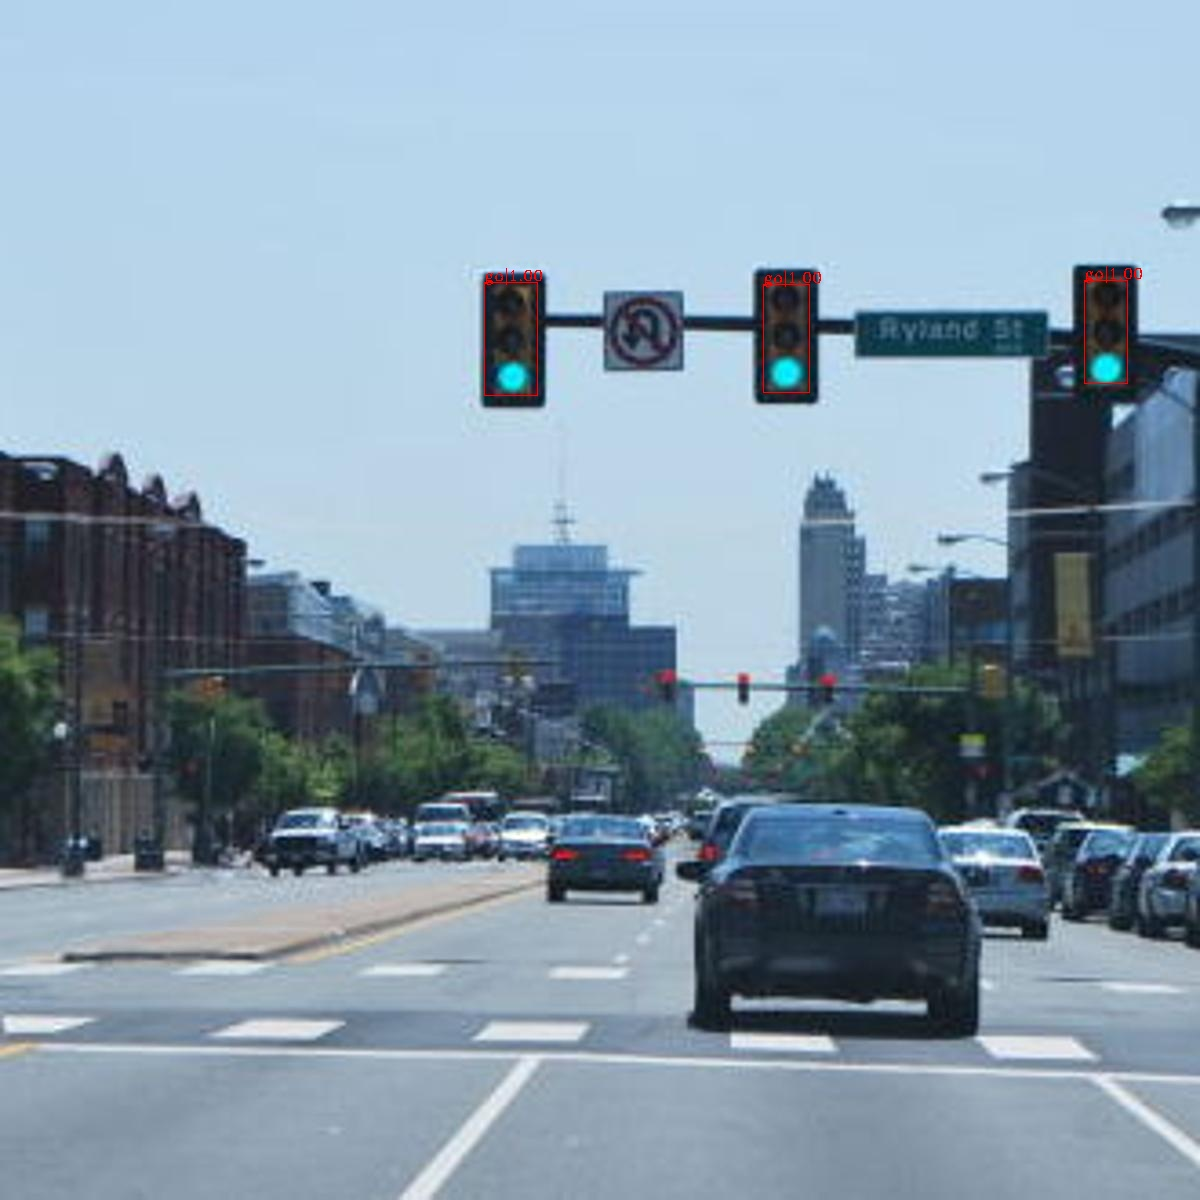

In [13]:
result = gtf.Predict(img_path="Test_images/test2.jpg",
           out_img_path="result.jpg",
           thresh=0.5);
from IPython.display import Image
Image(filename='result.jpg')

Inference Time: 0.07252645492553711 sec
Saving Time: 0.012881994247436523 sec


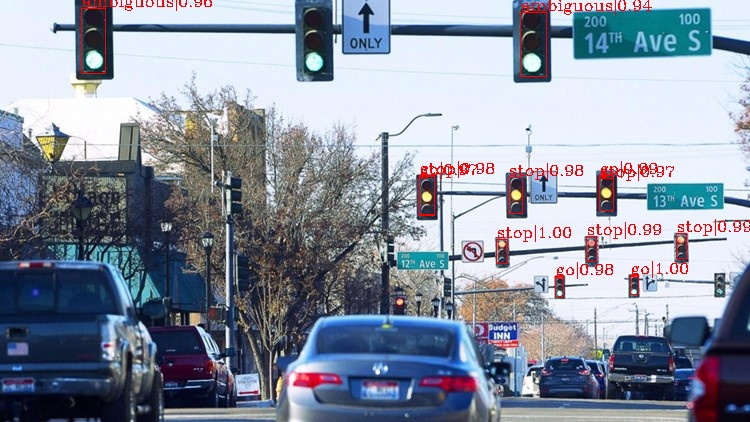

In [15]:
result = gtf.Predict(img_path="Test_images/test3.jpg",
           out_img_path="result.jpg",
           thresh=0.9);
from IPython.display import Image
Image(filename='result.jpg')

Inference Time: 0.07643008232116699 sec
Saving Time: 0.01838064193725586 sec


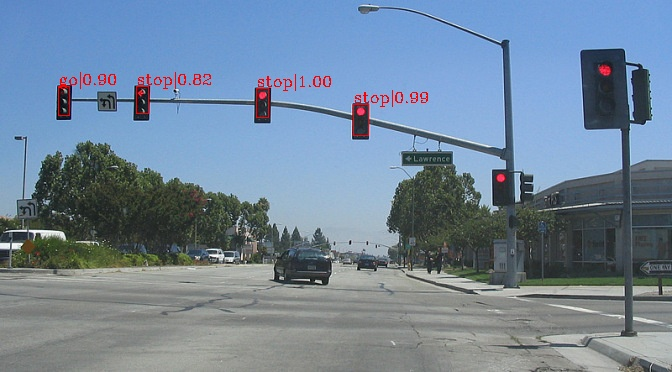

In [19]:
result = gtf.Predict(img_path="Test_images/test4.jpg",
           out_img_path="result.jpg",
           thresh=0.8);
from IPython.display import Image
Image(filename='result.jpg')

Inference Time: 0.07163524627685547 sec
Saving Time: 0.017673492431640625 sec


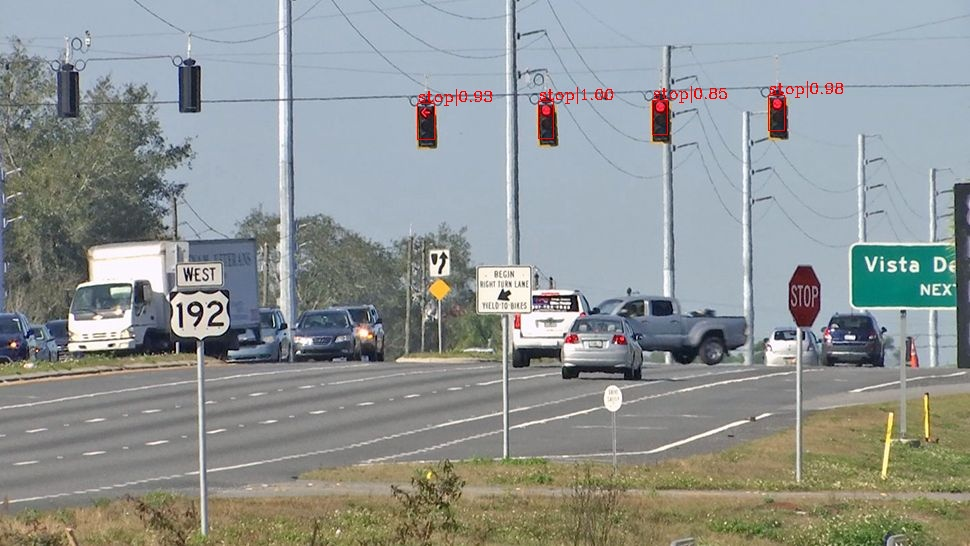

In [20]:
result = gtf.Predict(img_path="Test_images/test5.jpg",
           out_img_path="result.jpg",
           thresh=0.8);
from IPython.display import Image
Image(filename='result.jpg')

Inference Time: 0.07059025764465332 sec
Saving Time: 0.013109445571899414 sec


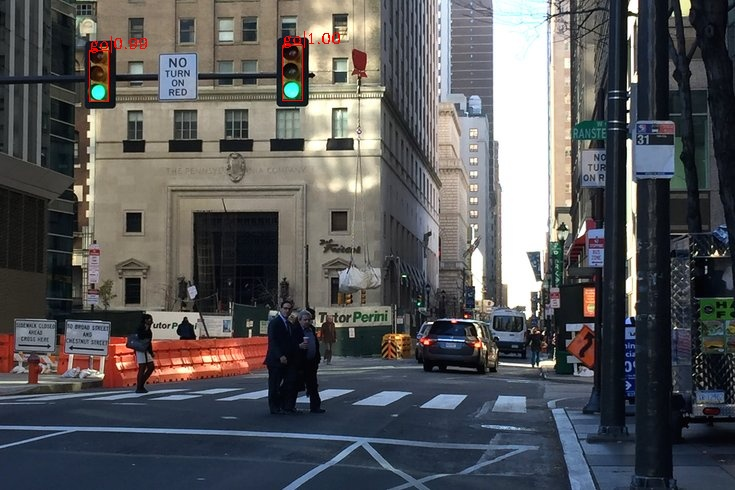

In [5]:
result = gtf.Predict(img_path="Test_images/test8.jpg",
           out_img_path="result.jpg",
           thresh=0.8);
from IPython.display import Image
Image(filename='result.jpg')

Inference Time: 0.0736687183380127 sec
Saving Time: 0.0255281925201416 sec


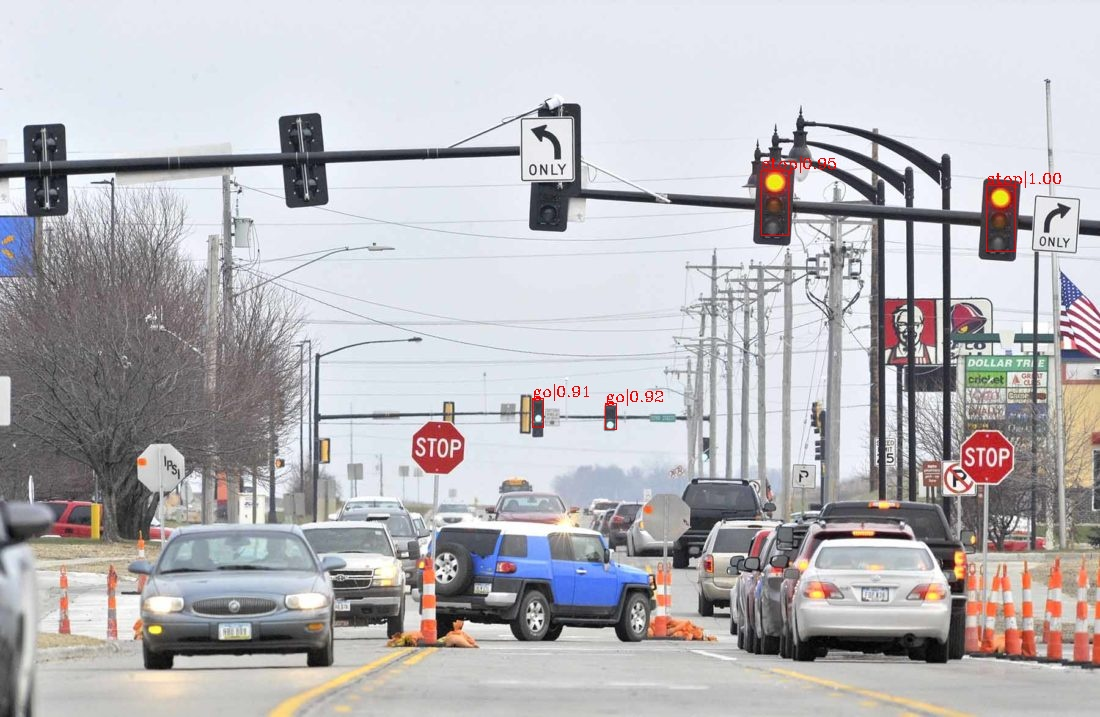

In [7]:
result = gtf.Predict(img_path="Test_images/test10.jpg",
           out_img_path="result.jpg",
           thresh=0.8);
from IPython.display import Image
Image(filename='result.jpg')

Inference Time: 0.06177067756652832 sec
Saving Time: 0.009553909301757812 sec


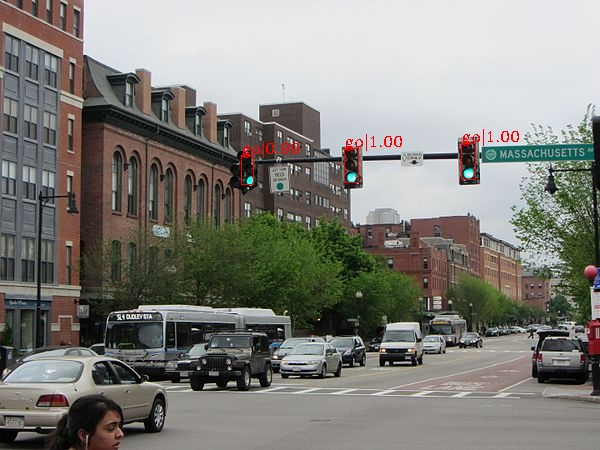

In [8]:
result = gtf.Predict(img_path="Test_images/test11.jpg",
           out_img_path="result.jpg",
           thresh=0.8);
from IPython.display import Image
Image(filename='result.jpg')

Inference Time: 0.05991101264953613 sec
Saving Time: 0.021856069564819336 sec


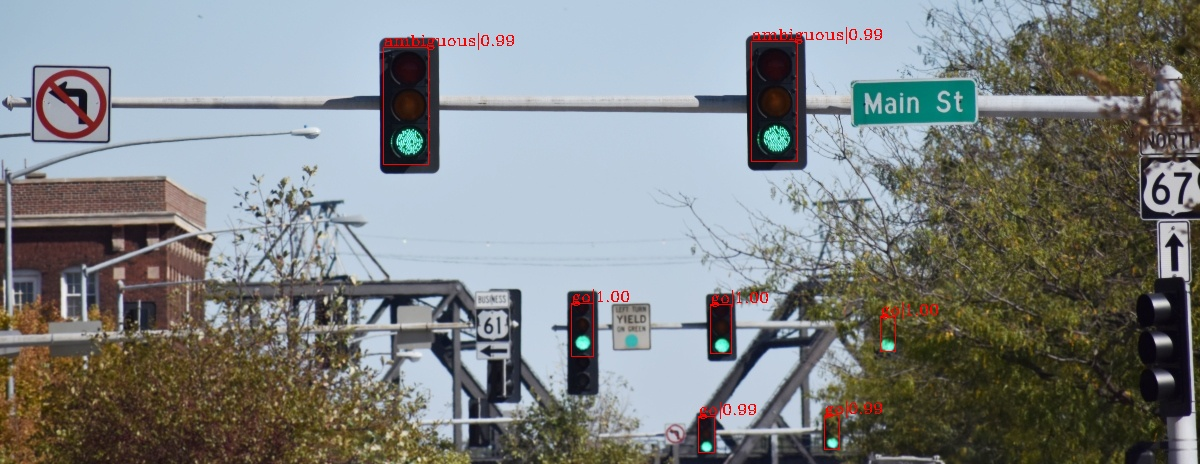

In [10]:
result = gtf.Predict(img_path="Test_images/test14.jpg",
           out_img_path="result.jpg",
           thresh=0.8);
from IPython.display import Image
Image(filename='result.jpg')

Inference Time: 0.07992792129516602 sec
Saving Time: 0.03680777549743652 sec


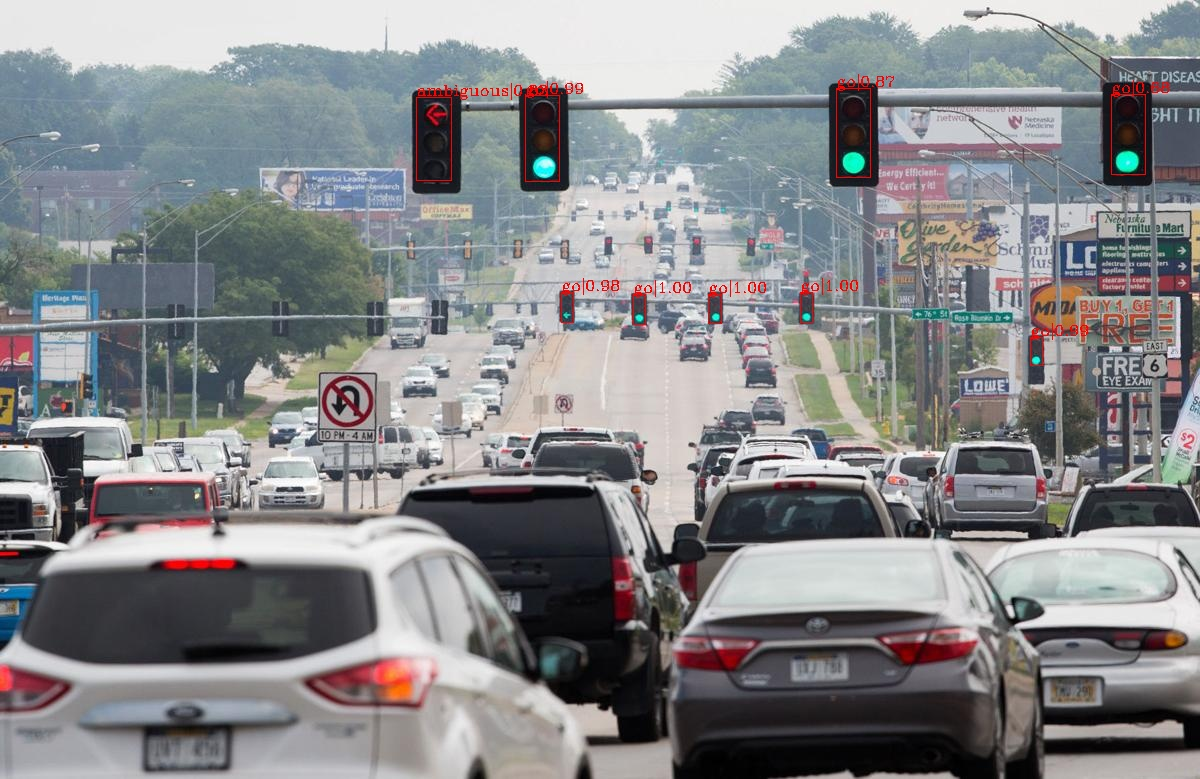

In [11]:
result = gtf.Predict(img_path="Test_images/test16.jpg",
           out_img_path="result.jpg",
           thresh=0.6);
from IPython.display import Image
Image(filename='result.jpg')